# PostgreSQL: read/write binary data using psycopg2

---
* author: Prasert Kanawattanachai
* e-mail: prasert.k@chula.ac.th
* [Chulalongkorn Business School, Thailand](https://www.cbs.chula.ac.th/en/home/)
---

In [1]:
# conda install psycopg2
import psycopg2

import pandas as pd
import os
import glob
from PIL import Image  # pip install pillow (for Python 3)
from io import BytesIO

In [2]:
print(f'psycopg2 version: {psycopg2.__version__}')
print(f'pandas   version: {pd.__version__}')

psycopg2 version: 2.7.6.1 (dt dec pq3 ext lo64)
pandas   version: 0.24.2


## PostgreSQL connection

In [3]:
user='postgres'
pwd='1234'
dbname='demo'
host='192.168.9.114'
port=5432
con = psycopg2.connect(host=host, database=dbname, user=user, password=pwd, port=port)
con.autocommit=True
print(con)
cur=con.cursor()

<connection object at 0x0000021BA48BD570; dsn: 'user=postgres password=xxx dbname=demo host=192.168.9.114 port=5432', closed: 0>


In [4]:
def create_table():
    sql_cmd = """
        drop table if exists media;
        CREATE TABLE media(
          id serial PRIMARY KEY,
          descr VARCHAR(255),
          filetype VARCHAR(30),
          stream bytea
        );
    """
    cur.execute(sql_cmd)


def insert_data(params):
    sql_cmd = """
       INSERT INTO media(descr, filetype, stream) VALUES(%s, %s, %s)
    """
    cur.execute(sql_cmd, params)

    
def read_bin(filename):
    with open(filename, mode='rb') as f:
        return f.read()


def write_bin(filename, data):
    with open(filename, mode='wb') as f:
        f.write(data)

In [5]:
def select_pil(params):
    sql_cmd = """
        SELECT stream, descr, filetype FROM media WHERE id = %s limit 1;
    """
    cur.execute(sql_cmd, params)
    row = cur.fetchone()
    if row:
        bytes_stream = BytesIO(row[0])
        img = Image.open(bytes_stream)
        return img
    return None

In [6]:
def select_data(params, outfile=None):
    sql_cmd = """
        SELECT stream, descr, filetype FROM media WHERE id = %s limit 1;
     """
    cur.execute(sql_cmd, params)
    row = cur.fetchone()
    if row:
        if not (outfile):
            outfile = f'{row[1]}.{row[2]}'
        write_bin(outfile, row[0])

In [7]:
def filename_ext(path):
    basename = os.path.basename(path)  # return filename.ext (no path)
    filename, ext = os.path.splitext(basename)
    # print(f'filename = # filename}, ext = {ext}')
    return filename, ext[1:]

In [8]:
def insert_files(pattern):
    for name in glob.glob(pattern):
        print(f'inserting file {name}')
#         print(filename_ext(name))
        filename, ext = filename_ext(name)
        insert_data((filename, ext, read_bin(name)))

In [9]:
create_table()

In [10]:
insert_data(('hand', 'png', read_bin(r'images/Hand.png')))

In [11]:
insert_data(('eye', 'png', read_bin(r'images/Eye.png')))

In [12]:
pd.read_sql('select * from media', con)

id descr filetype                                             stream
0   1  hand      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...
1   2   eye      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...

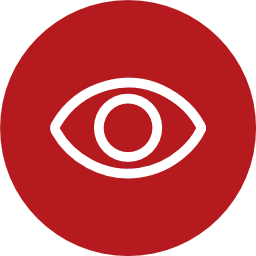

In [13]:
select_pil([2])

In [14]:
insert_files(r'images/*.jpg')

inserting file images\bear.jpg
inserting file images\robot.jpg


In [15]:
pd.read_sql('select * from media', con)

id  descr filetype                                             stream
0   1   hand      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...
1   2    eye      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...
2   3   bear      jpg  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'5', b'D...
3   4  robot      jpg  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'V', b'\...

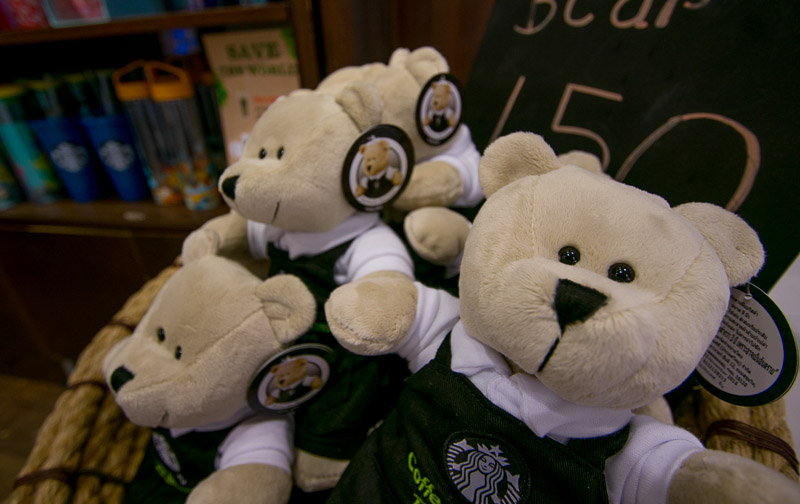

In [16]:
select_pil([3])

In [17]:
pd.read_sql('select * from media', con)

id  descr filetype                                             stream
0   1   hand      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...
1   2    eye      png  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...
2   3   bear      jpg  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'5', b'D...
3   4  robot      jpg  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'V', b'\...

In [18]:
insert_data(('coffee_sales', 'xlsx', read_bin(r'data/sales.xlsx')))

In [19]:
pd.read_sql('select * from media', con)

id         descr filetype  \
0   1          hand      png   
1   2           eye      png   
2   3          bear      jpg   
3   4         robot      jpg   
4   5  coffee_sales     xlsx   

                                              stream  
0  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
1  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
2  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'5', b'D...  
3  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'V', b'\...  
4  [b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00...

In [20]:
select_data([5], 'wow.xlsx')

In [21]:
select_data([1], 'new_hand.png')

In [22]:
insert_files(r'images/A*.png')

inserting file images\Archery.png
inserting file images\Assist.png
inserting file images\Athletics-WF.png


In [23]:
pd.read_sql('select * from media', con)

id         descr filetype  \
0   1          hand      png   
1   2           eye      png   
2   3          bear      jpg   
3   4         robot      jpg   
4   5  coffee_sales     xlsx   
5   6       Archery      png   
6   7        Assist      png   
7   8  Athletics-WF      png   

                                              stream  
0  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
1  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
2  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'5', b'D...  
3  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'V', b'\...  
4  [b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00...  
5  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
6  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
7  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...

In [24]:
insert_files(r'data/*.csv')

inserting file data\bbl.csv
inserting file data\mpg.csv


In [25]:
pd.read_sql('select * from media', con)

id         descr filetype  \
0   1          hand      png   
1   2           eye      png   
2   3          bear      jpg   
3   4         robot      jpg   
4   5  coffee_sales     xlsx   
5   6       Archery      png   
6   7        Assist      png   
7   8  Athletics-WF      png   
8   9           bbl      csv   
9  10           mpg      csv   

                                              stream  
0  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
1  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
2  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'5', b'D...  
3  [b'\xff', b'\xd8', b'\xff', b'\xe1', b'V', b'\...  
4  [b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00...  
5  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
6  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
7  [b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...  
8  [b'D', b'a', b't', b'e', b',', b'O', b'p', b'e...  
9  [b'"', b'm', b'a', b'n', b'u', b'f', b'a', b'c...

In [26]:
select_data([9], 'bbl.csv')

In [27]:
df=pd.read_csv('bbl.csv')
df

Date   Open   High    Low  Close   Adj Close     Volume
0   2017-01-31    NaN    NaN    NaN    NaN         NaN        NaN
1   2017-02-01  174.5  175.5  173.5  175.5  169.355362  5953500.0
2   2017-02-02  175.0  177.0  174.5  175.5  169.355362  5250500.0
3   2017-02-03  175.0  178.5  175.0  178.5  172.250336  5470600.0
4   2017-02-06  178.5  181.5  178.5  180.5  174.180313  8150800.0
5   2017-02-07  180.5  181.0  179.0  180.0  173.697815  3648600.0
6   2017-02-08  180.0  180.0  178.5  179.0  172.732819  2574200.0
7   2017-02-09  179.5  182.5  179.5  181.0  174.662796  7290700.0
8   2017-02-10  182.0  182.5  181.0  182.5  176.110275  3589100.0
9   2017-02-13  182.5  182.5  182.5  182.5  176.110275        0.0
10  2017-02-14  182.0  182.5  179.0  179.0  172.732819  2841700.0

In [28]:
con.commit()
con.close()